In [1]:
#导入必要的包
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import pre_process

In [2]:
#读取相关文件
train_path = '../data/train.csv'
test_path = '../data/test.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
train_data,test_data = pre_process.fill_inf(train_data,test_data)#填补inf值
train_data,test_data = pre_process.del_singular_feature(train_data,test_data)#删除单值属性

In [6]:
numerical_fea = list(train_data.select_dtypes(exclude=['object']).columns) 
category_fea = list(filter(lambda x: x not in numerical_fea,list(train_data.columns)))
print("numerical_fea:",numerical_fea)
print("category_fea:",category_fea)

numerical_fea: ['main_account_loan_no', 'main_account_active_loan_no', 'main_account_overdue_no', 'main_account_outstanding_loan', 'main_account_sanction_loan', 'main_account_disbursed_loan', 'sub_account_loan_no', 'sub_account_active_loan_no', 'sub_account_overdue_no', 'sub_account_outstanding_loan', 'sub_account_sanction_loan', 'sub_account_disbursed_loan', 'disbursed_amount', 'asset_cost', 'branch_id', 'supplier_id', 'manufacturer_id', 'area_id', 'employee_code_id', 'Driving_flag', 'passport_flag', 'credit_score', 'main_account_monthly_payment', 'sub_account_monthly_payment', 'last_six_month_new_loan_no', 'last_six_month_defaulted_no', 'average_age', 'credit_history', 'enquirie_no', 'loan_to_asset_ratio', 'total_account_loan_no', 'sub_account_inactive_loan_no', 'total_inactive_loan_no', 'main_account_inactive_loan_no', 'total_overdue_no', 'total_outstanding_loan', 'total_sanction_loan', 'total_disbursed_loan', 'total_monthly_payment', 'outstanding_disburse_ratio', 'main_account_tenu

In [8]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_iris

#方差选择法，返回值为特征选择后的数据
#参数threshold为方差的阈值
train_data = VarianceThreshold(threshold=3).fit_transform(train_data)
test_data = VarianceThreshold(threshold=3).fit_transform(test_data)


(150000, 48)

In [7]:
#过滤数值型类别特征 
def get_numerical_serial_fea(data,feas): 
    numerical_serial_fea = [] 
    numerical_noserial_fea = [] 
    for fea in feas: 
        temp = data[fea].nunique() 
        if temp <= 10: 
            numerical_noserial_fea.append(fea) 
            continue 
        numerical_serial_fea.append(fea) 
    return numerical_serial_fea,numerical_noserial_fea 
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(train_data,numerical_fea)
print("numerical_fea中的numerical_serial_fea:",numerical_serial_fea)
print("numerical_fea中的numerical_noserial_fea:",numerical_noserial_fea)

numerical_fea中的numerical_serial_fea: ['main_account_loan_no', 'main_account_active_loan_no', 'main_account_overdue_no', 'main_account_outstanding_loan', 'main_account_sanction_loan', 'main_account_disbursed_loan', 'sub_account_loan_no', 'sub_account_active_loan_no', 'sub_account_outstanding_loan', 'sub_account_sanction_loan', 'sub_account_disbursed_loan', 'disbursed_amount', 'asset_cost', 'branch_id', 'supplier_id', 'area_id', 'employee_code_id', 'credit_score', 'main_account_monthly_payment', 'sub_account_monthly_payment', 'last_six_month_new_loan_no', 'last_six_month_defaulted_no', 'average_age', 'credit_history', 'enquirie_no', 'loan_to_asset_ratio', 'total_account_loan_no', 'sub_account_inactive_loan_no', 'total_inactive_loan_no', 'main_account_inactive_loan_no', 'total_overdue_no', 'total_outstanding_loan', 'total_sanction_loan', 'total_disbursed_loan', 'total_monthly_payment', 'outstanding_disburse_ratio', 'main_account_tenure', 'sub_account_tenure', 'disburse_to_sactioned_ratio'

In [ ]:
train_data['loan_default'].value_counts()
#逾期的占少数17.6%

In [ ]:
columns = numerical_serial_fea
fig = plt.figure(figsize=(80,60),dpi=75)
for i in range(len(columns)):
    plt.subplot(7,8,i+1)
    sns.boxplot(train_data[columns[i]],orient='v',width=0.5)
    plt.ylabel(columns[i],fontsize=36)
plt.savefig('analysis_results/boxes.png')
plt.show()

In [9]:
def find_outliers(model,X,y,sigma=3):
    
    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X),index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X),index=y.index)
    
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid  = resid.std()
    
    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid-mean_resid)/std_resid
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('Mse=',mean_squared_error(y,y_pred))
    print('-------------------------------------------------------')
    
    print(len(outliers),'outliers;',' ALL data shape:',X.shape)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');
    
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('analysis_results/outliers.png')
    
    return outliers


R2= 0.027071031534741663
Mse= 0.14169772015777293
-------------------------------------------------------
0 outliers;  ALL data shape: (149995, 47)
nan


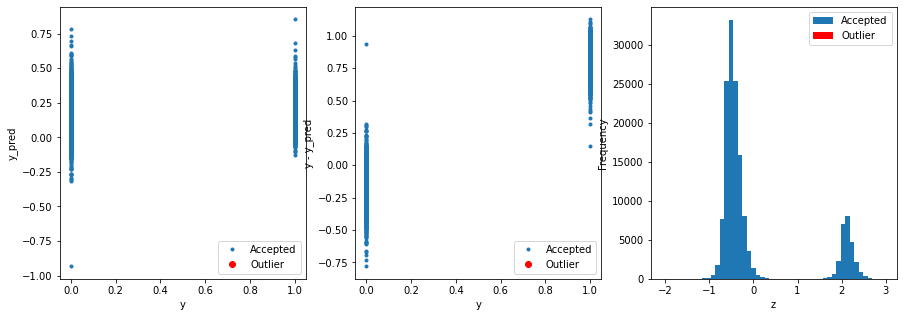

In [12]:
# 通过岭回归模型找出异常值，并绘制其分布
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
X_train = train_data.iloc[:,0:-1]
y_train = train_data.iloc[:,-1]
outliers = find_outliers(Ridge(),X_train,y_train)
outlier_index = list(outliers)
outlier_sum = np.sum(train_data.iloc[outlier_index]['loan_default'].values)
print(outlier_sum/len(outlier_index)*100)
train_data.drop(labels=outlier_index,inplace=True)
train_data = train_data.reset_index(drop=True)

R2= 0.14164407210518404
Mse= 80.02880651897091
-------------------------------------------------------
0 outliers;  ALL data shape: (29894, 46)
nan


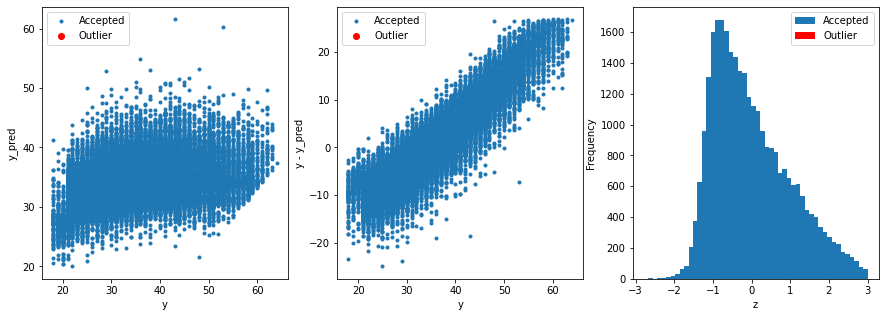

In [16]:
# 通过岭回归模型找出异常值，并绘制其分布
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
X_train = test_data.iloc[:,0:-1]
y_train = test_data.iloc[:,-1]
outliers = find_outliers(Ridge(),X_train,y_train)
outlier_index = list(outliers)

outlier_sum = np.sum(train_data.iloc[outlier_index]['loan_default'].values)
print(outlier_sum/len(outlier_index)*100)

test_data.drop(labels=outlier_index,inplace=True)
test_data = test_data.reset_index(drop=True)

In [ ]:
train_cols = 6
train_rows = len(train_data.columns)
plt.figure(figsize=(4*train_cols,4*train_rows))

i = 0
for col in train_data.columns:
    i+=1
    ax = plt.subplot(train_rows,train_cols,i)
    sns.distplot(train_data[col],fit=stats.norm)

    i+=1
    ax = plt.subplot(train_rows,train_cols,i)
    stats.probplot(train_data[col],plot=plt)

# tight_layout会自动调整子图参数，使之填充整个图像区域
plt.tight_layout()
plt.savefig('analysis_results/Q-Q.png')
plt.show()

In [ ]:
dist_cols = 6
dist_rows = len(test_data.columns)
plt.figure(figsize=(4*dist_cols,4*dist_rows))
i = 1
for col in test_data.columns:
    ax = plt.subplot(dist_rows,dist_cols,i)
    ax = sns.kdeplot(train_data[col],color='Red',shade=True)
    ax = sns.kdeplot(test_data[col],color='Blue',shade=True)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax = ax.legend(['train','test'])
    i+=1
plt.savefig('analysis_results/KDE.png')
plt.show()

In [ ]:
fcols = 6
frows = len(test_data.columns)
plt.figure(figsize=(5*fcols,4*frows))

i = 0
for col in test_data.columns:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col,y='loan_default',data=train_data,ax=ax,
               scatter_kws={'marker':'.','s':3,'alpha':0.3},line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('loan_default')
    
    i+=1
    ax = plt.subplot(frows,fcols,i)
    
    sns.distplot(train_data[col].dropna())
    plt.xlabel(col)
    
plt.tight_layout()
plt.savefig('analysis_results/linear_regression_for_each_feature.png')
plt.show()


In [ ]:
k = 10#len(train_data.columns)
train_corr = train_data.corr()
cols = train_corr.nlargest(k,'loan_default')['loan_default'].index

cm = np.corrcoef(train_data[cols].values.T)
hm = plt.subplots(figsize=(k,k))
hm = sns.heatmap(train_data[cols].corr(),annot=True,square=True)
plt.savefig('analysis_results/10-most-relavant.png')
plt.show()

In [ ]:
threshold = 0.5
k = len(train_data.columns)
corrmat = train_data.corr()
top_corr_features = corrmat.index[abs(corrmat['loan_default'])>threshold]
plt.figure(figsize=(k,k))
g = sns.heatmap(train_data[top_corr_features].corr(),annot=True,cmap='RdYlGn')

In [17]:
from sklearn.model_selection  import train_test_split
from sklearn import linear_model
from sklearn.metrics import f1_score
def calculate_f1(model):
    y_pred = model.predict(X_test)
    y_true = y_test
    score = f1_score(y_true, y_pred, average='macro')
    return score
#划分数据集
labels = train_data['loan_default'].values
features_scaler = train_data.drop(['loan_default'],axis=1).values
X_train,X_test, y_train, y_test = train_test_split(features_scaler, labels, test_size = 0.2, random_state = 0)
#训练逻辑回归模型
model = linear_model.LogisticRegression(n_jobs=-1)
model = model.fit(X_train, y_train)
print("f1:",calculate_f1(model))

f1: 0.45146190275923864


In [18]:
numerical_noserial_fea.pop()
#合并训练集和测试集
train_x = train_data.drop(['loan_default'],axis=1)
train_x['flag'] = 'train'
test_data['flag'] = 'test'

data_all = pd.concat([train_x,test_data],axis=0,ignore_index=True)
data_all.drop(numerical_noserial_fea,axis=1,inplace=True)

# 归一化
cols_numeric = [i for i in list(data_all.columns) if i!='flag']

def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax,axis=0)

In [19]:
print(f'There are {data_all.isnull().any().sum()} columns in train dataset with missing values.')

There are 0 columns in train dataset with missing values.


In [ ]:
train_data_process['loan_default'] = train_data['loan_default']
print(f'There are {train_data.isnull().any().sum()} columns in train dataset with missing values.')

In [20]:
train_data_process

NameError: name 'train_data_process' is not defined

In [32]:
train_data_process = data_all[data_all['flag']=='train']
train_data_process.drop(['flag'],axis=1,inplace=True)
print(f'There are {train_data_process.isnull().any().sum()} columns in train dataset with missing values.')
train_data_process = pd.concat([train_data_process,train_data['loan_default']],axis=1)
print(f'There are {train_data_process.isnull().any().sum()} columns in train dataset with missing values.')

There are 0 columns in train dataset with missing values.
There are 0 columns in train dataset with missing values.


In [33]:
test_data_process = data_all[data_all['flag']=='test']

In [36]:
def calculate_f1(model):
    y_pred = model.predict(X_test)
    y_true = y_test
    score = f1_score(y_true, y_pred, average='macro')
    return score
#划分数据集
labels = train_data_process['loan_default'].values
features_scaler = train_data_process.drop(['loan_default'],axis=1).values
X_train,X_test, y_train, y_test = train_test_split(features_scaler, labels, test_size = 0.2, random_state = 0)
#训练逻辑回归模型
model = linear_model.LogisticRegression(n_jobs=-1)
model = model.fit(X_train, y_train)
print("f1:",calculate_f1(model))

f1: 0.4523726338365656


In [ ]:
test_data_process
print(f'There are {test_data_process.isnull().any().sum()} columns in train dataset with missing values.')